# Machine Learning Algorithm Testing:
1. Linear Regression
2. Decision Tree
3. Neural Network

In [1]:
from scipy.io import netcdf
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import math
import os,sys
import matplotlib.style

import matplotlib

matplotlib.style.use('classic')
import time

In [2]:
import glob,os,sys
os.chdir('C:/Users/yashg/Documents/Cloud_Data_Files')
def read_files(extensions,location):
    l=[]
    for types in extensions:
        l.append(glob.glob(f'./{location}/*{types}'))
    l=[val for sublist in l for val in sublist]
    return l

k=read_files(['.cdf','.nc'],'KAZRARSCL')
m=read_files(['.cdf','.nc'],'Microbase')
r=read_files(['.cdf','.nc'],'Raman Lidar')
s=read_files(['.cdf','.nc'],'Surface')
e=read_files(['.cdf','.nc'],'Ext')
mp=read_files(['.cdf','.nc'],'Micropulse')
mwr=read_files(['.cdf','.nc'],'mwrret')
master=k+m+r+s+e+mp+mwr

def date_files(date,master=master):
    f=[]
    for file in master:
        if date in file:
            f.append(file)
    return f

def generate_cdfs(date):
    l=[]
    f=date_files(date)
    for file in f:
        l.append(Dataset(file))
    print('Output has 6 files')
    print('File order is\t1.KAZRARSCL\t2.Microbase\t3.Raman Lidar\t4. Surface\t5. Ext\t6.Micropulse\t 7.Mwrret')
    return l

In [3]:
k1,m1,r1,s1,e1,mp1,mwr1=generate_cdfs('20110505')

Output has 6 files
File order is	1.KAZRARSCL	2.Microbase	3.Raman Lidar	4. Surface	5. Ext	6.Micropulse	 7.Mwrret


In [4]:
tk=k1['time'][:]
hk=k1['height'][:]
tr=r1['time'][:]
hr=r1['height'][:]*1000
ref=10**(k1['reflectivity'][:]/10)
v=np.abs(k1['mean_doppler_velocity'][:])
temp=r1['temperature'][:]+273.15
lwc_mb=m1['liquid_water_content'][:]

In [5]:
def st_clustering(t1,h1,t2,h2):
    t_clust=[]
    h_clust=[]
    output_resolution=(len(t1),len(h1))
    data_resolution=(len(t2),len(h2))
    print('--------Start of clustering cycle--------')
    print(f'Changing time resolution from {len(t2)}->{len(t1)}')
    print(f'Changing height resolution from {len(h2)}->{len(h1)}')
    if len(t1)>len(t2):
        print('You are increasing time resolution')
        for i in t1:
            x=np.argmin(np.abs(i-t2))
            t_clust.append(x)
    else:
        print('You are decreasing time resolution')
        for i in range(len(t1)):
            if i!=len(t1)-1:
                ltemp=[m for m,x in enumerate(t2) if t1[i]<= x <=t1[i+1]]
                t_clust.append(ltemp)
            else:
                ltemp=[m for m,x in enumerate(t2) if t1[i]<= x]
                t_clust.append(ltemp) 
    if len(h1)>len(h2):
        print('You are increasing height resolution')
        for i in h1:
            x=np.argmin(np.abs(i-h2))
            h_clust.append(x)
    else:
        print('You are decreasing height resolution')     
        for i in range(len(h1)):
            if i!=len(h1)-1:
                ltemp=[m for m,x in enumerate(h2) if h1[i]<= x <=h1[i+1]]
                h_clust.append(ltemp)
            else:
                ltemp=[m for m,x in enumerate(h2) if h1[i]<= x]
                h_clust.append(ltemp) 
    print('--------End of clustering cycle--------')
    return t_clust,h_clust

In [6]:
tc,hc=st_clustering(tk,hk,tr,hr)
temp_cl=[]
for i in tc:
    for j in hc:
        temp_cl.append(temp[i,j])
temp_cl=np.array(temp_cl)
temp_cl=np.reshape(temp_cl,(len(tk),len(hk)))
ts=np.ma.filled(s1['time'][:])
ccn=np.ma.filled(s1['N_CCN'][:])
tc2,dummy=st_clustering(tk,hk,ts,hr)
ccn_ts=[ccn[i] for i in tc2]
u=[]
for p in ccn_ts:
    u.append([p]*len(hk))
ccn_cl=np.array(u)

--------Start of clustering cycle--------
Changing time resolution from 144->21600
Changing height resolution from 198->596
You are increasing time resolution
You are increasing height resolution
--------End of clustering cycle--------
--------Start of clustering cycle--------
Changing time resolution from 1440->21600
Changing height resolution from 198->596
You are increasing time resolution
You are increasing height resolution
--------End of clustering cycle--------


In [63]:
v.shape,ref.shape,lwc_mb.shape,ccn_cl.shape,temp_cl.shape
print(v.fill_value,ref.fill_value,lwc_mb.fill_value)

-9999.0 1e+20 -9999.0


In [52]:
vf=np.ndarray.flatten(np.ma.filled(v))
reff=np.ndarray.flatten(np.ma.filled(ref))
lwcf=np.ndarray.flatten(np.ma.filled(lwc_mb))
ccnf=np.ndarray.flatten(np.ma.filled(ccn_cl))
temf=np.ndarray.flatten(np.ma.filled(temp_cl))
data=np.column_stack((vf,reff,lwcf,ccnf,temf))

In [70]:
df={'v':vf,'ref':reff,'ccn':ccnf,'temp':temf,'lwc':lwcf}
d=pd.DataFrame(df)

In [71]:
data=d[(d['v']!=v.fill_value) & (d['ref']!=ref.fill_value) & ((d['lwc']!=lwc_mb.fill_value)) ]

In [73]:
X=data.iloc[:,:-1]
y=data.iloc[:,-1]

In [75]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.7,random_state=19)

In [76]:
from sklearn.linear_model import LinearRegression
reg=LinearRegression().fit(X_train,y_train)
coeff=reg.coef_
b=reg.intercept_
print(f'intercept={b}')
Xlist=['Velocity','Reflectivity','CCN','Temperature']
for i,f in enumerate(Xlist):
    print(f'{f}:{coeff[i]}')

intercept=0.10209758579730988
Velocity:0.0013444513315334916
Reflectivity:-0.00010453291179146618
CCN:-3.4180848160758615e-06
Temperature:-0.0003286342544015497


In [77]:
from sklearn.metrics import r2_score
ypred=reg.predict(X_test)
r2_score(y_test,ypred)

0.01578367457691654

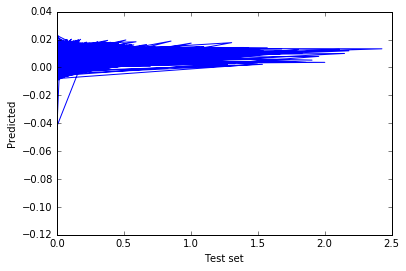

In [81]:
plt.plot(y_test,ypred)
plt.xlabel('Test set')
plt.ylabel('Predicted')
plt.show()

In [82]:
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
regressor=DecisionTreeRegressor(random_state=0)
regressor.fit(X_train,y_train)
y_pred=regressor.predict(X_test)
r2_score(y_test,y_pred)

0.3724413749951241

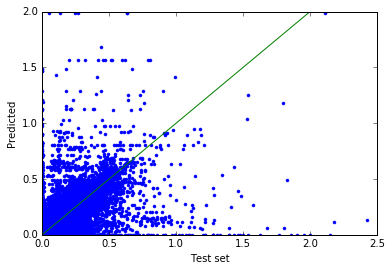

In [86]:
plt.plot(y_test,y_pred,'.')
plt.plot([0,2],[0,2])
plt.xlabel('Test set')
plt.ylabel('Predicted')
plt.show()

In [87]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeRegressor

In [95]:
regressor=DecisionTreeRegressor(random_state=0)
scores= cross_validate(regressor, X, y, cv=3,scoring=('r2','neg_mean_squared_error'),return_train_score=True)
print(scores['test_r2'])

[ -0.31584383  -0.12654599 -10.14430817]


In [101]:
print('For Regression')
for p in range(0,20):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.7,random_state=p)
    regressor=LinearRegression()
    regressor.fit(X_train,y_train)
    y_pred=regressor.predict(X_test)
    rr=r2_score(y_test,y_pred)   
    print(rr)

For Regression
0.015785178642192643
0.016004045064472505
0.015869921681710086
0.01595546417939575
0.01550104745398695
0.015951536829657664
0.015492756589570167
0.015841954939891045
0.016034766340873197
0.01576199219390817
0.015520525175372613
0.01548993965903911
0.01580384798246104
0.015206501623410307
0.015660599994997915
0.01576846300616197
0.015798268795611192
0.015624555037665688
0.01578145706652201
0.01578367457691654


In [98]:
print('For Decision Tree')
for p in range(0,20):
    regressor=DecisionTreeRegressor(random_state=p)
    regressor.fit(X_train,y_train)
    y_pred=regressor.predict(X_test)
    rr=r2_score(y_test,y_pred)   
    print(rr)

For Decision Tree
0.3724413749951241
0.36992103610330995
0.3588689343613337
0.391296716036337
0.3875036363845086
0.3739010724429681
0.387433002822375
0.4033981816103329
0.3569970628881849
0.39341263594301934
0.398483893984828
0.3951805619847115
0.38677654244847626
0.4042580451397687
0.38013366942514226
0.37040940107227704
0.3858830754038377
0.37121966006778817
0.3809929904139584
0.37535700098412406


In [102]:
#Constructing Neural Network
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor


  TensorFlow's `tf-nightly` package will soon be updated to TensorFlow 2.0.

  Please upgrade your code to TensorFlow 2.0:
    * https://www.tensorflow.org/beta/guide/migration_guide

  Or install the latest stable TensorFlow 1.X release:
    * `pip install -U "tensorflow==1.*"`

  Otherwise your code may be broken by the change.

  


In [114]:
scaler_x=MinMaxScaler()
scaler_y=MinMaxScaler()
xscale=scaler_x.fit_transform(X)
y=np.array(y).reshape((-1,1))
yscale=scaler_y.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(xscale, yscale)

In [119]:
model = Sequential()
model.add(Dense(12, input_dim=4, kernel_initializer='normal', activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 12)                60        
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 173
Trainable params: 173
Non-trainable params: 0
_________________________________________________________________


In [132]:
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
history=model.fit(X_train, y_train, epochs=50, batch_size=50,  verbose=1, validation_split=0.2)

Train on 357314 samples, validate on 89329 samples
Epoch 1/50
357314/357314 [==============================] - 7s 19us/sample - loss: 1.8072e-04 - mean_squared_error: 1.8072e-04 - mean_absolute_error: 0.0030 - val_loss: 2.0181e-04 - val_mean_squared_error: 2.0181e-04 - val_mean_absolute_error: 0.0040
Epoch 2/50
357314/357314 [==============================] - 8s 22us/sample - loss: 1.7987e-04 - mean_squared_error: 1.7987e-04 - mean_absolute_error: 0.0030 - val_loss: 1.9444e-04 - val_mean_squared_error: 1.9444e-04 - val_mean_absolute_error: 0.0024
Epoch 3/50
357314/357314 [==============================] - 8s 22us/sample - loss: 1.7935e-04 - mean_squared_error: 1.7935e-04 - mean_absolute_error: 0.0030 - val_loss: 1.8940e-04 - val_mean_squared_error: 1.8940e-04 - val_mean_absolute_error: 0.0023
Epoch 4/50
357314/357314 [==============================] - 8s 22us/sample - loss: 1.7896e-04 - mean_squared_error: 1.7896e-04 - mean_absolute_error: 0.0030 - val_loss: 2.0036e-04 - val_mean_squar

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error'])


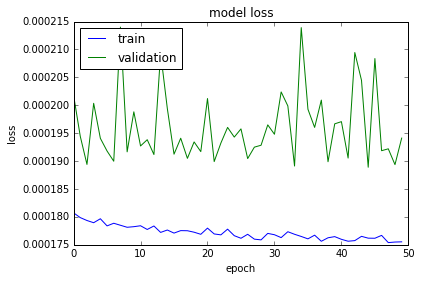

In [133]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [134]:
xnew=scaler_x.transform(X_test)
ynew=model.predict(xnew)
ynew = scaler_y.inverse_transform(ynew)

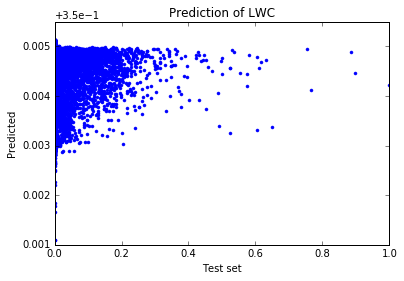

In [137]:
plt.plot(y_test,ynew,'.')
plt.xlabel('Test set')
plt.ylabel('Predicted')
plt.title('Prediction of LWC')
plt.show()